## **Open Source Installation** (For Reference)
Requirements:
- python >= 3.9

We highly recommend CUDA when using TorchRec. If using CUDA:
- cuda >= 11.8

Installing TorchRec will also install [FBGEMM](https://github.com/pytorch/fbgemm), a collection of CUDA kernels and GPU enabled operations to run

In [47]:
!pip3 install --pre torch --index-url https://download.pytorch.org/whl/nightly/cu121 -U
!pip3 install fbgemm_gpu --index-url https://download.pytorch.org/whl/nightly/cu121
!pip3 install torchmetrics==1.0.3
!pip3 install torchrec --index-url https://download.pytorch.org/whl/nightly/cu121

# Intro to TorchRec

### Embeddings
When building recommendation systems, categorical features typically have massive cardinalities, posts, users, ads, etc.

In order to represent these entities and model these relationships, **embeddings** are used. In machine learning, **embeddings are a vectors of real numbers in a high-dimensional space used to represent meaning in complex data like words, images, or users**.


### Embeddings in RecSys

Now you might wonder, how are these embeddings generated in the first place? Well, embeddings are represented as individual rows in an **Embedding Table**, also referred to as embedding weights. The reason for this is that embeddings/embedding table weights are trained just like all of the other weights of the model via gradient descent!

Embedding tables are simply a large matrix for storing embeddings, with two dimensions (B, N), where
* B is the number of embeddings stored by the table
* N is the number of dimensions per embedding (N-dimensional embedding).


The inputs to embedding tables represent embedding lookups to retrieve the embedding for a specific index/row. In recommendation systems, such as those used in Meta, unique IDs are not only used for specific users, but also across entites like posts and ads to serve as lookup indices to respective embedding tables!

Embeddings are trained in RecSys through the following process:
1. **Input/lookup indices are fed into the model, as unique IDs**. IDs are hashed to the total size of the embedding table to prevent issues when the ID > # of rows
2. Embeddings are then retrieved and **pooled, such as taking the sum or mean of the embeddings**. This is required as there can be a variable # of embeddings per example while the model expects consistent shapes.
3. The **embeddings are used in conjunction with the rest of the model to produce a prediction**, such as [Click-Through Rate (CTR)](https://support.google.com/google-ads/answer/2615875?hl=en) for an Ad.
4. The loss is calculated with the prediction and the label for an example, and **all weights of the model are updated through gradient descent and backpropogation, including the embedding weights** that were associated with the example.

These embeddings are crucial for representing categorical features, such as users, posts, and ads, in order to capture relationships and make good recommendations. Meta AI's [Deep learning recommendation model](https://arxiv.org/abs/1906.00091) (DLRM) paper talks more about the technical details of using embedding tables in RecSys.

This tutorial will introduce the concept of embeddings, showcase TorchRec specific modules/datatypes, and depict how distributed training works with TorchRec.

In [1]:
import torch

I0918 202025.568 _utils_internal.py:314] NCCL_DEBUG env var is set to None
I0918 202025.571 _utils_internal.py:323] NCCL_DEBUG is INFO from /etc/nccl.conf


## Embeddings in PyTorch
[`torch.nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html): Embedding table where forward pass returns the embeddings themselves as is.

[`torch.nn.EmbeddingBag`](https://pytorch.org/docs/stable/generated/torch.nn.EmbeddingBag.html): Embedding table where forward pass returns embeddings that are then pooled, i.e. sum or mean. Otherwise known as **Pooled Embeddings**

In this section, we will go over a very brief introduction with doing embedding lookups through passing in indices into the table. Check out the links for each for more sophisticated use cases and experiments!

In [2]:
num_embeddings, embedding_dim = 10, 4

# Initialize our embedding table
weights = torch.rand(num_embeddings, embedding_dim)
print("Weights:", weights)

Weights: tensor([[0.6269, 0.3844, 0.3567, 0.2157],
        [0.1389, 0.4360, 0.5552, 0.1743],
        [0.7882, 0.6698, 0.5491, 0.7563],
        [0.2951, 0.1978, 0.1244, 0.5379],
        [0.0659, 0.5433, 0.4665, 0.8800],
        [0.9593, 0.1084, 0.5537, 0.6705],
        [0.5422, 0.8178, 0.1714, 0.2302],
        [0.0637, 0.1407, 0.3465, 0.3193],
        [0.4163, 0.1239, 0.6150, 0.0990],
        [0.6188, 0.5297, 0.2801, 0.1449]])


In [3]:
# Pass in pre generated weights just for example, typically weights are randomly initialized
embedding_collection = torch.nn.Embedding(
    num_embeddings, embedding_dim, _weight=weights
)
embedding_bag_collection = torch.nn.EmbeddingBag(
    num_embeddings, embedding_dim, _weight=weights
)

# Print out the tables, we should see the same weights as above
print("Embedding Collection Table: ", embedding_collection.weight)
print("Embedding Bag Collection Table: ", embedding_bag_collection.weight)

# Lookup rows (ids for embedding ids) from the embedding tables
# 2D tensor with shape (batch_size, ids for each batch)
ids = torch.tensor([[1, 3]])
print("Input row IDS: ", ids)

Embedding Collection Table:  Parameter containing:
tensor([[0.6269, 0.3844, 0.3567, 0.2157],
        [0.1389, 0.4360, 0.5552, 0.1743],
        [0.7882, 0.6698, 0.5491, 0.7563],
        [0.2951, 0.1978, 0.1244, 0.5379],
        [0.0659, 0.5433, 0.4665, 0.8800],
        [0.9593, 0.1084, 0.5537, 0.6705],
        [0.5422, 0.8178, 0.1714, 0.2302],
        [0.0637, 0.1407, 0.3465, 0.3193],
        [0.4163, 0.1239, 0.6150, 0.0990],
        [0.6188, 0.5297, 0.2801, 0.1449]], requires_grad=True)
Embedding Bag Collection Table:  Parameter containing:
tensor([[0.6269, 0.3844, 0.3567, 0.2157],
        [0.1389, 0.4360, 0.5552, 0.1743],
        [0.7882, 0.6698, 0.5491, 0.7563],
        [0.2951, 0.1978, 0.1244, 0.5379],
        [0.0659, 0.5433, 0.4665, 0.8800],
        [0.9593, 0.1084, 0.5537, 0.6705],
        [0.5422, 0.8178, 0.1714, 0.2302],
        [0.0637, 0.1407, 0.3465, 0.3193],
        [0.4163, 0.1239, 0.6150, 0.0990],
        [0.6188, 0.5297, 0.2801, 0.1449]], requires_grad=True)
Input row ID

In [4]:
embeddings = embedding_collection(ids)

# Print out the embedding lookups
# You should see the specific embeddings be the same as the rows (ids) of the embedding tables above
print("Embedding Collection Results: ")
print(embeddings)
print("Shape: ", embeddings.shape)

Embedding Collection Results: 
tensor([[[0.1389, 0.4360, 0.5552, 0.1743],
         [0.2951, 0.1978, 0.1244, 0.5379]]], grad_fn=<EmbeddingBackward0>)
Shape:  torch.Size([1, 2, 4])


In [5]:
# nn.EmbeddingBag default pooling is mean, so should be mean of batch dimension of values above
pooled_embeddings = embedding_bag_collection(ids)

print("Embedding Bag Collection Results: ")
print(pooled_embeddings)
print("Shape: ", pooled_embeddings.shape)

# nn.EmbeddingBag is the same as nn.Embedding but just with pooling (mean, sum, etc.)
# We can see that the mean of the embeddings of embedding_collection is the same as the output of the embedding_bag_collection
print("Mean: ", torch.mean(embedding_collection(ids), dim=1))

Embedding Bag Collection Results: 
tensor([[0.2170, 0.3169, 0.3398, 0.3561]], grad_fn=<EmbeddingBagBackward0>)
Shape:  torch.Size([1, 4])
Mean:  tensor([[0.2170, 0.3169, 0.3398, 0.3561]], grad_fn=<MeanBackward1>)


Congratulations! Now you have a basic understanding on how to use embedding tables --- one of the foundations of modern recommendation systems! These tables represent entities and their relationships. For example, the relationship between a given user and the pages & posts they have liked.

# TorchRec

Now you know how to use embedding tables, one of the foundations of modern recommendation systems! These tables represent entities and relationships, such as users, pages, posts, etc. Given that these entities are always increasing, a **hash** function is typically applied to make sure the ids are within the bounds of a certain embedding table. However, in order to represent a vast amount of entities and reduce hash collisions, these tables can become quite massive (think about # of ads for example). In fact, these tables can become so massive that they won't be able to fit on 1 GPU, even with 80G of memory!

In order to train models with massive embedding tables, sharding these tables across GPUs is required, which then introduces a whole new set of problems/opportunities in parallelism and optimization. Luckily, we have the TorchRec library that has encountered, consolidated, and addressed many of these concerns. TorchRec serves as a **library that provides primitives for large scale distributed embeddings**.

From here on out, we will explore the major features of the TorchRec library. We will start with torch.nn.Embedding and will extend that to custom TorchRec modules, explore distributed training environment with generating a sharding plan for embeddings, look at inherent TorchRec optimizations, and extend the model to be ready for inference in C++. Below is a quick outline of what the journey will consist of - buckle in!

1. TorchRec Modules and DataTypes
2. Distributed Training, Sharding, and Optimizations
3. Inference


In [6]:
import torchrec

## TorchRec Modules and Datatypes

### From EmbeddingBag to EmbeddingBagCollection
We have already explored [`torch.nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) and [`torch.nn.EmbeddingBag`](https://pytorch.org/docs/stable/generated/torch.nn.EmbeddingBag.html).

TorchRec extends these modules by creating collections of embeddings, in other words modules that can have multiple embedding tables, with [`EmbeddingCollection`](https://pytorch.org/torchrec/torchrec.modules.html#torchrec.modules.embedding_modules.EmbeddingCollection) and [`EmbeddingBagCollection`](https://pytorch.org/torchrec/torchrec.modules.html#torchrec.modules.embedding_modules.EmbeddingBagCollection). We will use `EmbeddingBagCollection` to represent a group of EmbeddingBags.

Here, we create an EmbeddingBagCollection (EBC) with two embedding bags, 1 representing **products** and 1 representing **users**. Each table, `product_table` and `user_table`, is represented by 64 dimension embedding of size 4096.

In [7]:
ebc = torchrec.EmbeddingBagCollection(
    device="cpu",
    tables=[
        torchrec.EmbeddingBagConfig(
            name="product_table",
            embedding_dim=64,
            num_embeddings=4096,
            feature_names=["product"],
            pooling=torchrec.PoolingType.SUM,
        ),
        torchrec.EmbeddingBagConfig(
            name="user_table",
            embedding_dim=64,
            num_embeddings=4096,
            feature_names=["user"],
            pooling=torchrec.PoolingType.SUM,
        )
    ]
)
print(ebc.embedding_bags)

ModuleDict(
  (product_table): EmbeddingBag(4096, 64, mode='sum')
  (user_table): EmbeddingBag(4096, 64, mode='sum')
)


Let’s inspect the forward method for EmbeddingBagcollection and the module’s inputs and outputs.

In [8]:
import inspect

# Let's look at the EmbeddingBagCollection forward method
# What is a KeyedJaggedTensor and KeyedTensor?
print(inspect.getsource(ebc.forward))

    def forward(self, features: KeyedJaggedTensor) -> KeyedTensor:
        """
        Args:
            features (KeyedJaggedTensor): KJT of form [F X B X L].

        Returns:
            KeyedTensor
        """
        flat_feature_names: List[str] = []
        for names in self._feature_names:
            flat_feature_names.extend(names)
        inverse_indices = reorder_inverse_indices(
            inverse_indices=features.inverse_indices_or_none(),
            feature_names=flat_feature_names,
        )
        pooled_embeddings: List[torch.Tensor] = []
        feature_dict = features.to_dict()
        for i, embedding_bag in enumerate(self.embedding_bags.values()):
            for feature_name in self._feature_names[i]:
                f = feature_dict[feature_name]
                res = embedding_bag(
                    input=f.values(),
                    offsets=f.offsets(),
                    per_sample_weights=f.weights() if self._is_weighted else None,
                )

### TorchRec Input/Output Data Types
TorchRec has distinct data types for input and output of its modules: `JaggedTensor`, `KeyedJaggedTensor`, and `KeyedTensor`. Now you might ask, why create new datatypes to represent sparse features? To answer that question, we must understand how sparse features are represented in code.

Sparse features are otherwise known as `id_list_feature` and `id_score_list_feature`, and are the **IDs** that will be used as indices to an embedding table to retrieve the embedding for that ID. To give a very simple example, imagine a single sparse feature being Ads that a user interacted with. The input itself would be a set of Ad IDs that a user interacted with, and the embeddings retrieved would be a semantic representation of those Ads. The tricky part of representing these features in code is that in each input example, **the number of IDs is variable**. 1 day a user might have interacted with only 1 ad while the next day they interact with 3.

A simple representation is shown below, where we have a `lengths` tensor denoting how many indices are in an example for a batch and a `values` tensor containing the indices themselves.



In [9]:
# Batch Size 2
# 1 ID in example 1, 2 IDs in example 2
id_list_feature_lengths = torch.tensor([1, 2])

# Values (IDs) tensor: ID 5 is in example 1, ID 7, 1 is in example 2
id_list_feature_values = torch.tensor([5, 7, 1])

Let’s look at the offsets as well as what is contained in each Batch

In [10]:
# Lengths can be converted to offsets for easy indexing of values
id_list_feature_offsets = torch.cumsum(id_list_feature_lengths, dim=0)

print("Offsets: ", id_list_feature_offsets)
print("First Batch: ", id_list_feature_values[: id_list_feature_offsets[0]])
print(
    "Second Batch: ",
    id_list_feature_values[id_list_feature_offsets[0] : id_list_feature_offsets[1]],
)

Offsets:  tensor([1, 3])
First Batch:  tensor([5])
Second Batch:  tensor([7, 1])


In [11]:
from torchrec import JaggedTensor

# JaggedTensor is just a wrapper around lengths/offsets and values tensors!
jt = JaggedTensor(values=id_list_feature_values, lengths=id_list_feature_lengths)

# Automatically compute offsets from lengths
print("Offsets: ", jt.offsets())

# Convert to list of values
print("List of Values: ", jt.to_dense())

# __str__ representation
print(jt)

Offsets:  tensor([0, 1, 3])
List of Values:  [tensor([5]), tensor([7, 1])]
JaggedTensor({
    [[5], [7, 1]]
})



In [12]:
from torchrec import KeyedJaggedTensor

# JaggedTensor represents IDs for 1 feature, but we have multiple features in an EmbeddingBagCollection
# That's where KeyedJaggedTensor comes in! KeyedJaggedTensor is just multiple JaggedTensors for multiple id_list_feature_offsets
# From before, we have our two features "product" and "user". Let's create JaggedTensors for both!

product_jt = JaggedTensor(
    values=torch.tensor([1, 2, 1, 5]), lengths=torch.tensor([3, 1])
)
user_jt = JaggedTensor(values=torch.tensor([2, 3, 4, 1]), lengths=torch.tensor([2, 2]))

# Q1: How many batches are there, and which values are in the first batch for product_jt and user_jt?
kjt = KeyedJaggedTensor.from_jt_dict({"product": product_jt, "user": user_jt})

# Look at our feature keys for the KeyedJaggedTensor
print("Keys: ", kjt.keys())

# Look at the overall lengths for the KeyedJaggedTensor
print("Lengths: ", kjt.lengths())

# Look at all values for KeyedJaggedTensor
print("Values: ", kjt.values())

# Can convert KJT to dictionary representation
print("to_dict: ", kjt.to_dict())

# KeyedJaggedTensor(KJT) string representation
print(kjt)

# Q2: What are the offsets for the KeyedJaggedTensor?

Keys:  ['product', 'user']
Lengths:  tensor([3, 1, 2, 2])
Values:  tensor([1, 2, 1, 5, 2, 3, 4, 1])
to_dict:  {'product': <torchrec.sparse.jagged_tensor.JaggedTensor object at 0x7f4f9ac06260>, 'user': <torchrec.sparse.jagged_tensor.JaggedTensor object at 0x7f4f71200310>}
KeyedJaggedTensor({
    "product": [[1, 2, 1], [5]],
    "user": [[2, 3], [4, 1]]
})



In [13]:
# Now we can run a forward pass on our ebc from before
result = ebc(kjt)
result

In [14]:
# Result is a KeyedTensor, which contains a list of the feature names and the embedding results
print(result.keys())

# The results shape is [2, 128], as batch size of 2. Reread previous section if you need a refresher on how the batch size is determined
# 128 for dimension of embedding. If you look at where we initialized the EmbeddingBagCollection, we have two tables "product" and "user" of dimension 64 each
# meaning emebddings for both features are of size 64. 64 + 64 = 128
print(result.values().shape)

# Nice to_dict method to determine the embeddings that belong to each feature
result_dict = result.to_dict()
for key, embedding in result_dict.items():
    print(key, embedding.shape)

['product', 'user']
torch.Size([2, 128])
product torch.Size([2, 64])
user torch.Size([2, 64])


Congrats! Give yourself a pat on the back for making it this far.

## Distributed Training and Sharding
Now that we have a grasp on TorchRec modules and data types, it's time to take it to the next level.

Remember, TorchRec's main purpose is to provide primitives for distributed embeddings. So far, we've only worked with embedding tables on 1 device. This has been possible given how small the embedding tables have been, but in a production setting this isn't generally the case. Embedding tables often get massive, where 1 table can't fit on a single GPU, creating the requirement for multiple devices and a distributed environment

In this section, we will explore setting up a distributed environment, exactly how actual production training is done, and explore sharding embedding tables, all with Torchrec.

**This section will also only use 1 gpu, though it will be treated in a distributed fashion. This is only a limitation for training, as training has a process per gpu. Inference does not run into this requirement**

In [15]:
# Here we set up our torch distributed environment
# WARNING: You can only call this cell once, calling it again will cause an error
# as you can only initialize the process group once

import os

import torch.distributed as dist

# Set up environment variables for distributed training
# RANK is which GPU we are on, default 0
os.environ["RANK"] = "0"
# How many devices in our "world", since Bento can only handle 1 process, 1 GPU
os.environ["WORLD_SIZE"] = "1"
# Localhost as we are training locally
os.environ["MASTER_ADDR"] = "localhost"
# Port for distributed training
os.environ["MASTER_PORT"] = "29500"

# Note - you will need a V100 or A100 to run tutorial as!
# nccl backend is for GPUs, gloo is for CPUs
dist.init_process_group(backend="nccl")

print(f"Distributed environment initialized: {dist}")

W0918 20:20:51.492902 3508277 torch/_utils_internal.py:1050] Set ENV TORCH_NCCL_SLEEP_AFTER_EXCEPTION = True from JK ai_infra/pytorch_distributed:sleep_after_exception
W0918 20:20:51.494689 3508277 torch/_utils_internal.py:1050] Set ENV TORCH_NCCL_DUMP_ON_TIMEOUT = True from JK ai_infra/pytorch_distributed:dump_on_nccl_timeout_1
W0918 20:20:51.495571 3508277 torch/_utils_internal.py:1050] Set ENV TORCH_NCCL_TRACE_BUFFER_SIZE = 2000 from JK ai_infra/pytorch_distributed:torch_nccl_trace_buffer_size
W0918 20:20:51.497527 3508277 torch/_utils_internal.py:1050] Set ENV TORCH_NCCL_TRACE_CPP_STACK = False from JK ai_infra/pytorch_distributed:torch_nccl_trace_cpp_stack
W0918 20:20:51.498366 3508277 torch/_utils_internal.py:1050] Set ENV TORCH_NCCL_ENABLE_TIMING = False from JK ai_infra/pytorch_distributed:torch_nccl_enable_timing
W0918 20:20:51.499985 3508277 torch/_utils_internal.py:1050] Set ENV TORCH_NCCL_ENABLE_MONITORING = False from JK ai_infra/pytorch_distributed:torch_nccl_enable_monit

Distributed environment initialized: <module 'torch.distributed' from '/mnt/xarfuse/uid-28984/b2995003-seed-nspid4026533636_cgpid73128133-ns-4026533633/torch/distributed/__init__.py'>


### Distributed Embeddings

We have already worked with the main TorchRec module: `EmbeddingBagCollection`. We have examined how it works along with how data is represented in TorchRec. However, we have not yet explored one of the main parts of TorchRec, which is **distributed embeddings**.

GPUs are the most popular choice for ML workloads by far today, as they are able to do magnitudes more floating point operations/s ([FLOPs](https://en.wikipedia.org/wiki/FLOPS)) than CPU. However, GPUs come with the limitation of scarce fast memory (HBM which is analgous to RAM for CPU), typically ~10s of GBs.

A RecSys model can contain embedding tables that far exceed the memory limit for 1 GPU, hence the need for distribution of the embedding tables across multiple GPUs, otherwise known as **model parallel**. On the other hand, **data parallel** is where the entire model is replicated on each GPU, which each GPU taking in a distinct batch of data for training, syncing gradients on the backwards pass.

Parts of the model that **require less compute but more memory (embeddings) are distributed with model parallel** while parts that **require more compute and less memory (dense layers, MLP, etc.) are distributed with data parallel**.


### Sharding
In order to distribute an embedding table, we split up the embedding table into parts and place those parts onto different devices, also known as “sharding”.

There are many ways to shard embedding tables. The most common ways are:
* Table-Wise: the table is placed entirely onto one device
* Column-Wise: columns of embedding tables are sharded
* Row-Wise: rows of embedding tables are sharded


### Sharded Modules
While all of this seems like a lot to deal with and implement, you're in luck. **TorchRec provides all the primitives for easy distributed training/inference**! In fact, TorchRec modules have two corresponding classes for working with any TorchRec module in a distributed environment:
1. The module sharder: This class exposes a `shard` API that handles sharding a TorchRec Module, producing a sharded module.
    *  For `EmbeddingBagCollection`, the sharder is [`EmbeddingBagCollectionSharder`](https://pytorch.org/torchrec/torchrec.distributed.html#torchrec.distributed.embeddingbag.EmbeddingBagCollectionSharder)
2. Sharded module: This class is a sharded variant of a TorchRec module. It has the same input/output as a the regular TorchRec module, but much more optimized and works in a distributed environment.
    * For `EmbeddingBagCollection`, the sharded variant is [`ShardedEmbeddingBagCollection`](https://pytorch.org/torchrec/torchrec.distributed.html#torchrec.distributed.embeddingbag.ShardedEmbeddingBagCollection)

Every TorchRec module has an unsharded and sharded variant.
* The unsharded version is meant to be prototyped and experimented with
* The sharded version is meant to be used in a distributed environment for distributed training/inference.

The sharded versions of TorchRec modules, for example EmbeddingBagCollection, will handle everything that is needed for Model Parallelism, such as communication between GPUs for distributing embeddings to the correct GPUs.


In [40]:
# Refresher of our EmbeddingBagCollection module
ebc

EmbeddingBagCollection(
  (embedding_bags): ModuleDict(
    (product_table): EmbeddingBag(4096, 64, mode='sum')
    (user_table): EmbeddingBag(4096, 64, mode='sum')
  )
)

In [41]:
from torchrec.distributed.embeddingbag import EmbeddingBagCollectionSharder
from torchrec.distributed.planner import EmbeddingShardingPlanner, Topology
from torchrec.distributed.types import ShardingEnv

# Corresponding sharder for EmbeddingBagCollection module
sharder = EmbeddingBagCollectionSharder()

# ProcessGroup from torch.distributed initialized 2 cells above
pg = dist.GroupMember.WORLD
assert pg is not None, "Process group is not initialized"

print(f"Process Group: {pg}")

Process Group: <torch.distributed.distributed_c10d.ProcessGroup object at 0x7f4f71258ff0>


### Planner

Before we can show how sharding works, we must know about the **planner**, which helps us determine the best sharding configuration.

Given a number of embedding tables and a number of ranks, there are many different sharding configurations that are possible. For example, given 2 embedding tables and 2 GPUs, you can:
* Place 1 table on each GPU
* Place both tables on a single GPU and no tables on the other
* Place certain rows/columns on each GPU

Given all of these possibilities, we typically want a sharding configuration that is optimal for performance.

That is where the planner comes in. The planner is able to determine given the # of embedding tables and the # of GPUs, what is the optimal configuration. Turns out, this is incredibly difficult to do manually, with tons of factors that engineers have to consider to ensure an optimal sharding plan. Luckily, TorchRec provides an auto planner when the planner is used. The TorchRec planner:
* assesses memory constraints of hardware,
* estimates compute based on memory fetches as embedding lookups,
* addresses data specific factors,
* considers other hardware specifics like bandwidth to generate an optimal sharding plan.

In order to take into consideration all these variables, The TorchRec planner can take in [various amounts of data for embedding tables, constraints, hardware information, and topology](https://github.com/pytorch/torchrec/blob/main/torchrec/distributed/planner/planners.py#L147-L155) to aid in generating the optimal sharding plan for a model, which is routinely provided across stacks


To learn more about sharding, see our [sharding tutorial](https://pytorch.org/tutorials/advanced/sharding.html).

In [42]:
# In our case, 1 GPU and compute on CUDA device
planner = EmbeddingShardingPlanner(
    topology=Topology(
        world_size=1,
        compute_device="cuda",
    )
)

# Run planner to get plan for sharding
plan = planner.collective_plan(ebc, [sharder], pg)

print(f"Sharding Plan generated: {plan}")

I0918 203945.841 stats.py:522] ##################################################################################################################################################################################################################################################################################################
I0918 203945.842 stats.py:522] #                                                                                                                                   --- Planner Statistics ---                                                                                                                                   #
I0918 203945.843 stats.py:522] #                                                                                                          --- Evaluated 256 proposal(s), found 256 possible plan(s), ran for 0.05s ---                                                                                                          #
I0918 203945.844 stats.py:522] # -

Sharding Plan generated: module: 

    param     | sharding type | compute kernel | ranks
------------- | ------------- | -------------- | -----
product_table | table_wise    | fused          | [0]  
user_table    | table_wise    | fused          | [0]  

    param     | shard offsets | shard sizes |   placement  
------------- | ------------- | ----------- | -------------
product_table | [0, 0]        | [4096, 64]  | rank:0/cuda:0
user_table    | [0, 0]        | [4096, 64]  | rank:0/cuda:0


### Planner Result
As you can see, when running the planner there is quite a bit of output above. We can see a ton of stats being calculated along with where our tables end up being placed.

The result of running the planner is a static plan, which can be reused for sharding! This allows sharding to be static for production models instead of determining a new sharding plan everytime. Below, we use the sharding plan to finally generate our `ShardedEmbeddingBagCollection.`

In [43]:
# The static plan that was generated
plan

ShardingPlan(plan={'': {'product_table': ParameterSharding(sharding_type='table_wise', compute_kernel='fused', ranks=[0], sharding_spec=EnumerableShardingSpec(shards=[ShardMetadata(shard_offsets=[0, 0], shard_sizes=[4096, 64], placement=rank:0/cuda:0)]), cache_params=None, enforce_hbm=None, stochastic_rounding=None, bounds_check_mode=None, output_dtype=None, key_value_params=None), 'user_table': ParameterSharding(sharding_type='table_wise', compute_kernel='fused', ranks=[0], sharding_spec=EnumerableShardingSpec(shards=[ShardMetadata(shard_offsets=[0, 0], shard_sizes=[4096, 64], placement=rank:0/cuda:0)]), cache_params=None, enforce_hbm=None, stochastic_rounding=None, bounds_check_mode=None, output_dtype=None, key_value_params=None)}})

In [44]:
env = ShardingEnv.from_process_group(pg)

# Shard the EmbeddingBagCollection module using the EmbeddingBagCollectionSharder
sharded_ebc = sharder.shard(ebc, plan.plan[""], env, torch.device("cuda"))

print(f"Sharded EBC Module: {sharded_ebc}")

I0918 203946.974 split_table_batched_embeddings_ops_training.py:712] Using global weight decay = False
I0918 203946.976 split_table_batched_embeddings_ops_training.py:1025] [TBE=9117d22d-957a-4e51-ab31-2924018e5b97] Contents: ['product_table', 'user_table']
I0918 203946.977 split_table_batched_embeddings_ops_training.py:1025] [TBE=9117d22d-957a-4e51-ab31-2924018e5b97] Using fused exact_sgd with optimizer_args=OptimizerArgs(stochastic_rounding=True, gradient_clipping=False, max_gradient=1.0, max_norm=0.0, learning_rate=0.01, eps=1e-08, beta1=0.9, beta2=0.999, step_ema=10000, step_swap=10000, step_start=0, step_mode=2, weight_decay=0.0, weight_decay_mode=0, eta=0.001, momentum=0.9, counter_halflife=-1, adjustment_iter=-1, adjustment_ub=1.0, learning_rate_mode=-1, grad_sum_decay=-1, tail_id_threshold=0, is_tail_id_thresh_ratio=0, total_hash_size=8192, weight_norm_coefficient=0.0, lower_bound=0.0, regularization_mode=0)
I0918 203946.978 split_table_batched_embeddings_ops_training.py:1025] 

Sharded EBC Module: ShardedEmbeddingBagCollection(
  (lookups): 
   GroupedPooledEmbeddingsLookup(
      (_emb_modules): ModuleList(
        (0): BatchedFusedEmbeddingBag(
          (_emb_module): SplitTableBatchedEmbeddingBagsCodegen()
        )
      )
    )
   (_output_dists): 
   TwPooledEmbeddingDist()
  (embedding_bags): ModuleDict(
    (product_table): Module()
    (user_table): Module()
  )
)


#### Awaitable
Remember that TorchRec is a highly optimized library for distributed embeddings. A concept that TorchRec introduces to enable higher performance for training on GPU is a [`LazyAwaitable`](https://pytorch.org/torchrec/torchrec.distributed.html#torchrec.distributed.types.LazyAwaitable). You will see `LazyAwaitable` types as outputs of various sharded TorchRec modules. All a `LazyAwaitable` does is delay calculating some result as long as possible, and it does it by acting like an async type.

In [45]:
from typing import List

from torchrec.distributed.types import LazyAwaitable


# Demonstrate a LazyAwaitable type
class ExampleAwaitable(LazyAwaitable[torch.Tensor]):
    def __init__(self, size: List[int]) -> None:
        super().__init__()
        self._size = size

    def _wait_impl(self) -> torch.Tensor:
        return torch.ones(self._size)


awaitable = ExampleAwaitable([3, 2])
awaitable.wait()

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])

In [46]:
kjt = kjt.to("cuda")
output = sharded_ebc(kjt)
# The output of our sharded EmbeddingBagCollection module is a an Awaitable?
print(output)

In [47]:
kt = output.wait()
# Now we have out KeyedTensor after calling .wait()
# If you are confused as to why we have a KeyedTensor output,
# give yourself a refresher on the unsharded EmbeddingBagCollection module
print(type(kt))

print(kt.keys())

print(kt.values().shape)

# Same output format as unsharded EmbeddingBagCollection
result_dict = kt.to_dict()
for key, embedding in result_dict.items():
    print(key, embedding.shape)

<class 'torchrec.sparse.jagged_tensor.KeyedTensor'>
['product', 'user']
torch.Size([2, 128])
product torch.Size([2, 64])
user torch.Size([2, 64])


### Adding in the Optimizer

You may have noticed we're missing one key part of model training, the optimizer! The recommended way to apply the optimizer in TorchRec is through PyTorch's `apply_optimizer_in_backward` API. This gives you parameter level granualtiy and as such lets you define different optimizers or optimizer parameters for each paramter in your model.

With this level of control, you can define a different optimizer for a set of parameters or for embedding_bags as a whole. A key thing to note here, you need to be aware of is the parameter naming. EmbeddingBagCollections will be named something similar to `embedding_bags....` and EmbeddingCollections `embeddings...`. Inspect the model parameters through `model.named_parameters()` to understand how your model parameters are named.

TorchRec uses `CombinedOptimizer` which contains `KeyedOptimizers` within. A `CombinedOptimizer` effectively makes it easy to handle multiple optimizers for various sub groups in the model. A `KeyedOptimizer` extends the `torch.optim.Optimizer` and is initialized through a dictionary of parameters exposes the parameters. Each `TBE` module in a `EmbeddingBagCollection` will have it's own KeyedOptimizer which all combined into one `CombinedOptimizer`.

#### Fused optimizer in TorchRec

Using DistributedModelParallel, the optimizer is fused, which means that the optimizer update is done in the backward. Hence the term "fused". This is an optimization in TorchRec and FBGEMM, the optimizer embedding gradients are not materialized and direclty applied to the parameters. This brings significant memory savings are embedding gradients are typically size of the parameters themselves. You can, however, choose to make the optimizer "dense" which does not apply this optimization and let's you inspect the embedding gradients or apply computations to it as you wish. A dense optimizer in this case would be your [canonical PyTorch model training loop with optimizer.](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) 

Once the optimizer is created through DistributedModelParallel, you still need to manage an optimizer for the dense parameters. This you will do through the canonical PyTorch training loop, to find the dense parameters, you can call `in_backward_optimizer_filter(model.named_parameters())`. Apply the dense optimizer to those parameters as you would a normal Torch optimizer and combine this and the model.fused_optimizer into one `CombinedOptimizer` that you can use in your training loop to `zero_grad` and `step` through.

#### Let's add an optimizer to our EmbeddingBagCollection
We will do this in two ways, which are equivalent, but give you options depending on your preferences
1. Passing optimizer kwargs through fused parameters (fused_params) in sharder
2. Through `apply_optimizer_in_backward` 
Note: `apply_optimizer_in_backward` converts the optimizer parameters to `fused_params` to pass to the `TBE` in the `EmbeddingBagCollection`/`EmbeddingCollection`.
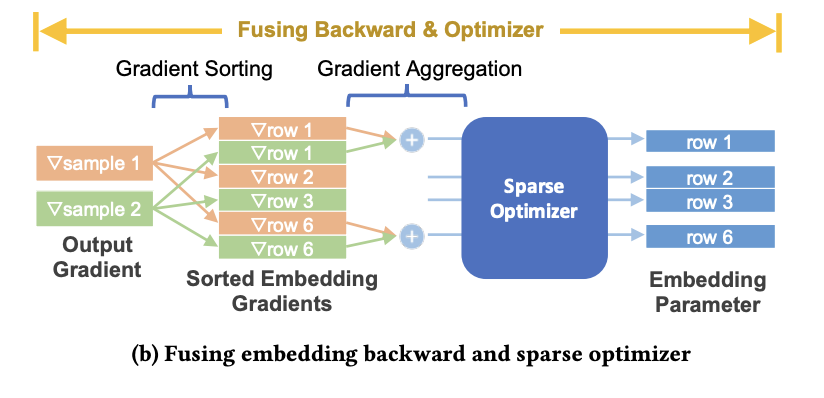

In [104]:
# Approach 1: passing optimizer kwargs through fused parameters
from torchrec.optim.optimizers import in_backward_optimizer_filter
from fbgemm_gpu.split_embedding_configs import EmbOptimType


# We initialize the sharder with
fused_params = {
    "optimizer": EmbOptimType.EXACT_ROWWISE_ADAGRAD,
    "learning_rate": 0.02,
    "eps": 0.002,
}

# Init sharder with fused_params
sharder_with_fused_params = EmbeddingBagCollectionSharder(fused_params=fused_params)

# We'll use same plan and unsharded EBC as before but this time with our new sharder
sharded_ebc_fused_params = sharder_with_fused_params.shard(ebc, plan.plan[""], env, torch.device("cuda"))

# Looking at the optimizer of each, we can see that the learning rate changed, which indicates our optimizer has been applied correclty.
# We can also look at the TBE logs of the cell to see that our new optimizer is indeed being applied
print(f"Original Sharded EBC fused optimizer: {sharded_ebc.fused_optimizer}")
print(f"Sharded EBC with fused parameters fused optimizer: {sharded_ebc_fused_params.fused_optimizer}")

# We can also check through the filter, we set include=True to show us the parameters that have an optimizer applied to them
dict(in_backward_optimizer_filter(sharded_ebc_fused_params.named_parameters(), include=True))

I0918 212104.678 split_table_batched_embeddings_ops_training.py:712] Using global weight decay = False
I0918 212104.681 split_table_batched_embeddings_ops_training.py:1025] [TBE=1122ea02-d61b-48d1-91c1-3b7b8527ea13] Contents: ['product_table', 'user_table']
I0918 212104.681 split_table_batched_embeddings_ops_training.py:1025] [TBE=1122ea02-d61b-48d1-91c1-3b7b8527ea13] Using fused exact_row_wise_adagrad with optimizer_args=OptimizerArgs(stochastic_rounding=True, gradient_clipping=False, max_gradient=1.0, max_norm=0.0, learning_rate=0.02, eps=0.002, beta1=0.9, beta2=0.999, step_ema=10000, step_swap=10000, step_start=0, step_mode=2, weight_decay=0.0, weight_decay_mode=0, eta=0.001, momentum=0.9, counter_halflife=-1, adjustment_iter=-1, adjustment_ub=1.0, learning_rate_mode=-1, grad_sum_decay=-1, tail_id_threshold=0, is_tail_id_thresh_ratio=0, total_hash_size=8192, weight_norm_coefficient=0.0, lower_bound=0.0, regularization_mode=0)
I0918 212104.682 split_table_batched_embeddings_ops_train

Original Sharded EBC fused optimizer: : EmbeddingFusedOptimizer (
Parameter Group 0
    lr: 0.01
)
Sharded EBC with fused parameters fused optimizer: : EmbeddingFusedOptimizer (
Parameter Group 0
    lr: 0.02
)


{'embedding_bags.product_table.weight': Parameter containing:
 Parameter(TableBatchedEmbeddingSlice([[-0.0059, -0.0100, -0.0129,  ..., -0.0060,
                               0.0085, -0.0018],
                             [ 0.0055,  0.0149,  0.0130,  ..., -0.0099,
                              -0.0013, -0.0128],
                             [ 0.0055,  0.0072,  0.0066,  ..., -0.0057,
                               0.0046,  0.0028],
                             ...,
                             [ 0.0139, -0.0004,  0.0118,  ...,  0.0059,
                              -0.0127,  0.0018],
                             [ 0.0119, -0.0104,  0.0022,  ...,  0.0109,
                              -0.0099, -0.0042],
                             [-0.0024, -0.0066,  0.0084,  ..., -0.0105,
                               0.0034, -0.0137]], device='cuda:0')),
 'embedding_bags.user_table.weight': Parameter containing:
 Parameter(TableBatchedEmbeddingSlice([[ 0.0111, -0.0150,  0.0025,  ..., -0.0134,
       

In [105]:
from torch.distributed.optim import _apply_optimizer_in_backward as apply_optimizer_in_backward
import copy
# Approach 2: applying optimizer through apply_optimizer_in_backward
# Note: we need to call apply_optimizer_in_backward on unsharded model first and then shard it

# We can achieve the same result as we did in the previous
ebc_apply_opt = copy.deepcopy(ebc)
optimizer_kwargs = {"lr": 0.5, "momentum": 0.99}

for name, param in ebc_apply_opt.named_parameters():
    print(f"{name=}")
    apply_optimizer_in_backward(torch.optim.SGD, [param], optimizer_kwargs)

sharded_ebc_apply_opt = sharder.shard(ebc_apply_opt, plan.plan[""], env, torch.device("cuda"))
# Now when we print the optimizer, we will see our new learning rate, you can verify momentum through the TBE logs at the top of the cell output
print(sharded_ebc_apply_opt.fused_optimizer)

I0918 212105.606 split_table_batched_embeddings_ops_training.py:712] Using global weight decay = False
I0918 212105.610 split_table_batched_embeddings_ops_training.py:1025] [TBE=8c183a68-c646-4cf1-be7d-7d222ef4e925] Contents: ['product_table', 'user_table']
I0918 212105.611 split_table_batched_embeddings_ops_training.py:1025] [TBE=8c183a68-c646-4cf1-be7d-7d222ef4e925] Using fused exact_sgd with optimizer_args=OptimizerArgs(stochastic_rounding=True, gradient_clipping=False, max_gradient=1.0, max_norm=0.0, learning_rate=0.5, eps=1e-08, beta1=0.9, beta2=0.999, step_ema=10000, step_swap=10000, step_start=0, step_mode=2, weight_decay=0.0, weight_decay_mode=0, eta=0.001, momentum=0.99, counter_halflife=-1, adjustment_iter=-1, adjustment_ub=1.0, learning_rate_mode=-1, grad_sum_decay=-1, tail_id_threshold=0, is_tail_id_thresh_ratio=0, total_hash_size=8192, weight_norm_coefficient=0.0, lower_bound=0.0, regularization_mode=0)
I0918 212105.613 split_table_batched_embeddings_ops_training.py:1025] 

name='embedding_bags.product_table.weight'
name='embedding_bags.user_table.weight'
: EmbeddingFusedOptimizer (
Parameter Group 0
    lr: 0.5
)


### Anatomy of Sharded TorchRec modules

We have now successfully sharded an EmbeddingBagCollection given a sharding plan that we generated! The sharded module has common APIs from TorchRec which abstract away distributed communication/compute amongst multiple GPUs. In fact, these APIs are highly optimized for performance in training and inference. **Below are the three common APIs for distributed training/inference** that are provided by TorchRec:

1. **input_dist**: Handles distributing inputs from GPU to GPU

2. **lookups**: Does the actual embedding lookup in an optimized, batched manner using FBGEMM TBE (more on this later)

3. **output_dist**: Handles distributing outputs from GPU to GPU

The distribution of inputs/outputs is done through [NCCL Collectives](https://docs.nvidia.com/deeplearning/nccl/user-guide/docs/overview.html), namely [All-to-Alls](https://docs.nvidia.com/deeplearning/nccl/user-guide/docs/usage/p2p.html#all-to-all), which is where all GPUs send/receive data to and from one another. TorchRec interfaces with PyTorch distributed for collectives and provides clean abstractions to the end users, removing the concern for the lower level details.


The backwards pass does all of these collectives but in the reverse order for distribution of gradients. input_dist, lookup, and output_dist all depend on the sharding scheme. Since we sharded in a table-wise fashion, these APIs are modules that are constructed by [TwPooledEmbeddingSharding](https://pytorch.org/torchrec/torchrec.distributed.sharding.html#torchrec.distributed.sharding.tw_sharding.TwPooledEmbeddingSharding).


In [92]:
sharded_ebc

ShardedEmbeddingBagCollection(
  (lookups): 
   GroupedPooledEmbeddingsLookup(
      (_emb_modules): ModuleList(
        (0): BatchedFusedEmbeddingBag(
          (_emb_module): SplitTableBatchedEmbeddingBagsCodegen()
        )
      )
    )
   (_input_dists): 
   TwSparseFeaturesDist(
      (_dist): KJTAllToAll()
    )
   (_output_dists): 
   TwPooledEmbeddingDist(
      (_dist): PooledEmbeddingsAllToAll()
    )
  (embedding_bags): ModuleDict(
    (product_table): Module()
    (user_table): Module()
  )
)

In [93]:
# Distribute input KJTs to all other GPUs and receive KJTs
sharded_ebc._input_dists

[TwSparseFeaturesDist(
   (_dist): KJTAllToAll()
 )]

In [94]:
# Distribute output embeddingts to all other GPUs and receive embeddings
sharded_ebc._output_dists

[TwPooledEmbeddingDist(
   (_dist): PooledEmbeddingsAllToAll()
 )]

### Optimizing Embedding Lookups

In performing lookups for a collection of embedding tables, a trivial solution would be to iterate through all the `nn.EmbeddingBags` and do a lookup per table. This is exactly what the standard, unsharded TorchRec's `EmbeddingBagCollection` does. However, while this solution is simple, it is extremely slow.

[FBGEMM](https://github.com/pytorch/FBGEMM/tree/main/fbgemm_gpu) is a library that provides GPU operators (otherewise known as kernels) that are very optimized. One of these operators is known as **Table Batched Embedding** (TBE), provides two major optimizations:

* Table batching, which allows you to look up multiple embeddings with one kernel call.
* Optimizer Fusion, which allows the module to update itself given the canonical pytorch optimizers and arguments.

The `ShardedEmbeddingBagCollection` uses the FBGEMM TBE as the lookup instead of traditional `nn.EmbeddingBags` for optimized embedding lookups.

In [95]:
sharded_ebc._lookups

[GroupedPooledEmbeddingsLookup(
   (_emb_modules): ModuleList(
     (0): BatchedFusedEmbeddingBag(
       (_emb_module): SplitTableBatchedEmbeddingBagsCodegen()
     )
   )
 )]

### DistributedModelParallel

We have now explored sharding a single EmbeddingBagCollection! We were able to take the `EmbeddingBagCollectionSharder` and use the unsharded `EmbeddingBagCollection` to generate a `ShardedEmbeddingBagCollection` module. This workflow is fine, but typically when doing model parallel, [`DistributedModelParallel`](https://pytorch.org/torchrec/torchrec.distributed.html#torchrec.distributed.model_parallel.DistributedModelParallel) (DMP) is used as the standard interface. When wrapping your model (in our case `ebc`), with DMP, the following will occur:

1. Decide how to shard the model. DMP will collect the available ‘sharders’ and come up with a ‘plan’ of the optimal way to shard the embedding table(s) (i.e, the EmbeddingBagCollection)
2. Actually shard the model. This includes allocating memory for each embedding table on the appropriate device(s).

DMP takes in everything that we've just experimented with, like a static sharding plan, a list of sharders, etc. However, it also has some nice defaults to seamlessly shard a TorchRec model. In this toy example, since we have two EmbeddingTables and one GPU, TorchRec will place both on the single GPU.


In [96]:
ebc

EmbeddingBagCollection(
  (embedding_bags): ModuleDict(
    (product_table): EmbeddingBag(4096, 64, mode='sum')
    (user_table): EmbeddingBag(4096, 64, mode='sum')
  )
)

In [97]:
model = torchrec.distributed.DistributedModelParallel(ebc, device=torch.device("cuda"))

W0918 211908.013 comm.py:50] Could not determine LOCAL_WORLD_SIZE from environment, falling back to WORLD_SIZE.
I0918 211908.062 stats.py:522] ##################################################################################################################################################################################################################################################################################################
I0918 211908.063 stats.py:522] #                                                                                                                                   --- Planner Statistics ---                                                                                                                                   #
I0918 211908.064 stats.py:522] #                                                                                                          --- Evaluated 256 proposal(s), found 256 possible plan(s), ran for 0.05s ---                              

In [98]:
out = model(kjt)
out.wait()

In [99]:
model

DistributedModelParallel(
  (_dmp_wrapped_module): ShardedEmbeddingBagCollection(
    (lookups): 
     GroupedPooledEmbeddingsLookup(
        (_emb_modules): ModuleList(
          (0): BatchedFusedEmbeddingBag(
            (_emb_module): SplitTableBatchedEmbeddingBagsCodegen()
          )
        )
      )
     (_input_dists): 
     TwSparseFeaturesDist(
        (_dist): KJTAllToAll()
      )
     (_output_dists): 
     TwPooledEmbeddingDist(
        (_dist): PooledEmbeddingsAllToAll()
      )
    (embedding_bags): ModuleDict(
      (product_table): Module()
      (user_table): Module()
    )
  )
)

### Sharding Best Practices

Currently, our configuration is only sharding on 1 GPU (or rank), which is trivial: just place all the tables on 1 GPUs memory. However, in real production use cases, embedding tables are **typically sharded on hundreds of GPUs**, with different sharding methods such as table-wise, row-wise, and column-wise. It is incredibly important to determine a proper sharding configuration (to prevent out of memory issues) while keeping it balanced not only in terms of memory but also compute for optimal performance.

## Inference

Now that we are able to train distributed embeddings, how can we take the trained model and optimize it for inference? Inference is typically very sensitive to **performance and size of the model**. Running just the trained model in a Python environment is incredibly inefficient. There are two key differences between inference and training environments:
* **Quantization**: Inference models are typically quantized, where model parameters lose precision for lower latency in predictions and reduced model size. For example FP32 (4 bytes) in trained model to INT8 (1 byte) for each embedding weight. This is also necessary given the vast scale of embedding tables, as we want to use as few devices as possible for inference to minimize latency.
* **C++ environment**: Inference latency is a big deal, so in order to ensure ample performance, the model is typically ran in a C++ environment (along with situations where we don't have a Python runtime, like on device)

TorchRec provides primitives for converting a TorchRec model into being inference ready with:
* APIs for quantizing the model, introducing optimizations automatically with FBGEMM TBE
* sharding embeddings for distributed inference
* compiling the model to [TorchScript](https://pytorch.org/docs/stable/jit.html) (compatible in C++)

In this section, we will go over this entire workflow of:
* Quantizing the model
* Sharding the quantized model
* Compiling the sharded quantized model into TorchScript

In [33]:
ebc

EmbeddingBagCollection(
  (embedding_bags): ModuleDict(
    (product_table): EmbeddingBag(4096, 64, mode='sum')
    (user_table): EmbeddingBag(4096, 64, mode='sum')
  )
)

In [34]:
class InferenceModule(torch.nn.Module):
    def __init__(self, ebc: torchrec.EmbeddingBagCollection):
        super().__init__()
        self.ebc_ = ebc

    def forward(self, kjt: KeyedJaggedTensor):
        return self.ebc_(kjt)

In [35]:
module = InferenceModule(ebc)
for name, param in module.named_parameters():
    # Here, the parameters should still be FP32, as we are using a standard EBC
    # FP32 is default, regularly used for training
    print(name, param.shape, param.dtype)

ebc_.embedding_bags.product_table.weight torch.Size([4096, 64]) torch.float32
ebc_.embedding_bags.user_table.weight torch.Size([4096, 64]) torch.float32


### Quantization

As you can see above, the normal EBC contains embedding table weights as FP32 precision (32 bits for each weight). Here, we will use the TorchRec inference library to quantize the embedding weights of the model to INT8

In [36]:
from torch import quantization as quant
from torchrec.modules.embedding_configs import QuantConfig
from torchrec.quant.embedding_modules import (
    EmbeddingBagCollection as QuantEmbeddingBagCollection,
)


quant_dtype = torch.int8


qconfig = QuantConfig(
    # dtype of the result of the embedding lookup, post activation
    # torch.float generally for compatability with rest of the model
    # as rest of the model here usually isn't quantized
    activation=quant.PlaceholderObserver.with_args(dtype=torch.float),
    # quantized type for embedding weights, aka parameters to actually quantize
    weight=quant.PlaceholderObserver.with_args(dtype=quant_dtype),
)
qconfig_spec = {
    # Map of module type to qconfig
    torchrec.EmbeddingBagCollection: qconfig,
}
mapping = {
    # Map of module type to quantized module type
    torchrec.EmbeddingBagCollection: QuantEmbeddingBagCollection,
}


module = InferenceModule(ebc)

# Quantize the module
qebc = quant.quantize_dynamic(
    module,
    qconfig_spec=qconfig_spec,
    mapping=mapping,
    inplace=False,
)


print(f"Quantized EBC: {qebc}")

Quantized EBC: InferenceModule(
  (ebc_): QuantizedEmbeddingBagCollection(
    (_kjt_to_jt_dict): ComputeKJTToJTDict()
    (embedding_bags): ModuleDict(
      (product_table): Module()
      (user_table): Module()
    )
  )
)


In [37]:
kjt = kjt.to("cpu")

In [38]:
qebc(kjt)

In [39]:
# Once quantized, goes from parameters -> buffers, as no longer trainable
for name, buffer in qebc.named_buffers():
    # The shapes of the tables should be the same but the dtype should be int8 now
    # post quantization
    print(name, buffer.shape, buffer.dtype)

ebc_.embedding_bags.product_table.weight torch.Size([4096, 80]) torch.uint8
ebc_.embedding_bags.user_table.weight torch.Size([4096, 80]) torch.uint8


### Shard

Here we perform sharding of the TorchRec quantized model. This is to ensure we are using the performant module through FBGEMM TBE. Here we are using one device to be consistent with training (1 TBE).

In [40]:
from torchrec import distributed as trec_dist
from torchrec.distributed.shard import _shard_modules


sharded_qebc = _shard_modules(
    module=qebc,
    device=torch.device("cpu"),
    env=trec_dist.ShardingEnv.from_local(
        1,
        0,
    ),
)


print(f"Sharded Quantized EBC: {sharded_qebc}")

Sharded Quantized EBC: InferenceModule(
  (ebc_): ShardedQuantEmbeddingBagCollection(
    (lookups): 
     InferGroupedPooledEmbeddingsLookup()
    (_output_dists): ModuleList()
    (embedding_bags): ModuleDict(
      (product_table): Module()
      (user_table): Module()
    )
    (_input_dist_module): ShardedQuantEbcInputDist()
  )
)


In [41]:
sharded_qebc(kjt)

### Compilation
Now we have the optimized eager TorchRec inference model. The next step is to ensure that this model is loadable in C++, as currently it is only runnable in a Python runtime.

The recommended method of compilation at Meta is two fold: [torch.fx tracing](https://pytorch.org/docs/stable/fx.html) (generate intermediate representation of model) and converting the result to TorchScript, where TorchScript is C++ compatible.

In [42]:
from torchrec.fx import Tracer


tracer = Tracer(leaf_modules=["IntNBitTableBatchedEmbeddingBagsCodegen"])

graph = tracer.trace(sharded_qebc)
gm = torch.fx.GraphModule(sharded_qebc, graph)

print("Graph Module Created!")

Graph Module Created!


In [43]:
print(gm.code)


torch.fx._symbolic_trace.wrap("torchrec_distributed_quant_embeddingbag_flatten_feature_lengths")
torch.fx._symbolic_trace.wrap("torchrec_fx_utils__fx_marker")
torch.fx._symbolic_trace.wrap("torchrec_distributed_quant_embedding_kernel__unwrap_kjt")
torch.fx._symbolic_trace.wrap("torchrec_distributed_embedding_lookup_embeddings_cat_empty_rank_handle_inference")

def forward(self, kjt : torchrec_sparse_jagged_tensor_KeyedJaggedTensor):
    flatten_feature_lengths = torchrec_distributed_quant_embeddingbag_flatten_feature_lengths(kjt);  kjt = None
    _fx_marker = torchrec_fx_utils__fx_marker('KJT_ONE_TO_ALL_FORWARD_BEGIN', flatten_feature_lengths);  _fx_marker = None
    split = flatten_feature_lengths.split([2])
    getitem = split[0];  split = None
    to = getitem.to(device(type='cuda', index=0), non_blocking = True);  getitem = None
    _fx_marker_1 = torchrec_fx_utils__fx_marker('KJT_ONE_TO_ALL_FORWARD_END', flatten_feature_lengths);  flatten_feature_lengths = _fx_marker_1 = None
   

In [44]:
scripted_gm = torch.jit.script(gm)
print("Scripted Graph Module Created!")

/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


Scripted Graph Module Created!


In [46]:
print(scripted_gm.code)

def forward(self,
    kjt: __torch__.torchrec.sparse.jagged_tensor.KeyedJaggedTensor) -> __torch__.torchrec.sparse.jagged_tensor.KeyedTensor:
  _0 = __torch__.torchrec.distributed.quant_embeddingbag.flatten_feature_lengths
  _1 = __torch__.torchrec.fx.utils._fx_marker
  _2 = __torch__.torchrec.distributed.quant_embedding_kernel._unwrap_kjt
  _3 = __torch__.torchrec.distributed.embedding_lookup.embeddings_cat_empty_rank_handle_inference
  flatten_feature_lengths = _0(kjt, )
  _fx_marker = _1("KJT_ONE_TO_ALL_FORWARD_BEGIN", flatten_feature_lengths, )
  split = (flatten_feature_lengths).split([2], )
  getitem = split[0]
  to = (getitem).to(torch.device("cuda", 0), True, None, )
  _fx_marker_1 = _1("KJT_ONE_TO_ALL_FORWARD_END", flatten_feature_lengths, )
  _unwrap_kjt = _2(to, )
  getitem_1 = (_unwrap_kjt)[0]
  getitem_2 = (_unwrap_kjt)[1]
  _tensor_constant0 = self._tensor_constant0
  _tensor_constant1 = self._tensor_constant1
  ops.fbgemm.bounds_check_indices(_tensor_constant0, getitem_1

## Congrats!

You have now gone from training a distributed RecSys model all the way to making it inference ready. https://github.com/pytorch/torchrec/tree/main/torchrec/inference has a full example of how to load a TorchRec TorchScript model into C++ for inference.

## More resources
For more information, please see our [dlrm](https://github.com/facebookresearch/dlrm/tree/main/torchrec_dlrm/) example, which includes multinode training on the criteo terabyte dataset, using Meta’s [DLRM](https://arxiv.org/abs/1906.00091).